In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from transformers import DistilBertModel, DistilBertTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torchvision.models import ResNet18_Weights
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
# Define dataset class
class CustomImageTextDataset(Dataset):
    def __init__(self, image_dir, transform, tokenizer):
        self.dataset = datasets.ImageFolder(image_dir, transform=transform) 
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]  
        image_path, _ = self.dataset.imgs[idx]  # Get image filename

        # Extract text from filename 
        file_name = os.path.basename(image_path)
        text = os.path.splitext(file_name)[0]  # Remove extension
        text = text.replace('_', ' ')  # Replace underscores with spaces
        text = re.sub(r'\d+', '', text)  # Remove numbers

        # Tokenize text using DistilBERT
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            return_token_type_ids=False,
            padding='max_length',
            max_length=512,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'image': image,
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [15]:
# Define the model
class ResNetBERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetBERTClassifier, self).__init__()

        # Image feature extractor
        self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # Freeze layers for transfer learning
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Remove the final layer
        self.resnet.fc = nn.Identity()
        self.resnet_out_dim = 512  # Output feature size

        # Text feature extracter
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.bert_out_dim = self.bert.config.hidden_size  
        
        # Freeze all layers except the last transformer layer
        for name, param in self.bert.named_parameters():
            if "transformer.layer.5" in name:
                param.requires_grad = True  
            else:
                param.requires_grad = False  

        # Single FC layer for classification
        self.classifier = nn.Linear(self.resnet_out_dim + self.bert_out_dim, num_classes)

    def forward(self, image, input_ids, attention_mask):
        # Image pathway
        img_features = self.resnet(image)
        img_features = F.normalize(img_features, p=2, dim=1)  # L2 normalization

        # Text pathway
        text_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0]
        text_features = text_output[:, 0] 
        text_features = F.normalize(text_features, p=2, dim=1)  # L2 normalization

        # Combine image and text features
        combined_features = torch.cat((img_features, text_features), dim=1)

        # Pass through the classifier
        output = self.classifier(combined_features)
        return output

In [16]:
# Define function to evaluate the model
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []  # Store predicted class labels
    all_probs = []  # Store softmax probabilities

    with torch.no_grad():  # No gradient calculation needed
        for batch in dataloader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, attention_mask)
            probs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
            preds = torch.argmax(probs, dim=1)  # Get class predictions

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # Store probabilities

    accuracy = (torch.tensor(all_labels) == torch.tensor(all_preds)).sum().item() / len(all_labels)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'labels': all_labels,   # Return true labels for confusion matrix
        'predictions': all_preds,  # Return predicted class labels for confusion matrix
        'probabilities': all_probs  # Return softmax probabilities for ROC curve
    }

In [17]:
# Define test data directory
TEST_PATH   = "/work/TALC/enel645_2025w/garbage_data/CVPR_2024_dataset_Test"

# Define transformations for the test images
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Load datasets
test_dataset = CustomImageTextDataset(TEST_PATH, transform=transform, tokenizer=tokenizer)

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [18]:
# Define the model
model = ResNetBERTClassifier(num_classes=4).to(device)

# Load the best saved model weights
model.load_state_dict(torch.load('./best_model.pth', map_location=device))
model.eval()  # Set the model to evaluation mode

# Evaluate on the test set
eval_results = evaluate_model(model, test_dataloader, device)

In [19]:
# Print Evaluation Metrics
print("\n--- Evaluation Metrics on Test Set ---")
print(f"Test Accuracy : {eval_results['accuracy']:.4f}")
print(f"Precision     : {eval_results['precision']:.4f}")
print(f"Recall        : {eval_results['recall']:.4f}")
print(f"F1 Score      : {eval_results['f1_score']:.4f}")


--- Evaluation Metrics on Test Set ---
Test Accuracy : 0.8310
Precision     : 0.8373
Recall        : 0.8310
F1 Score      : 0.8299


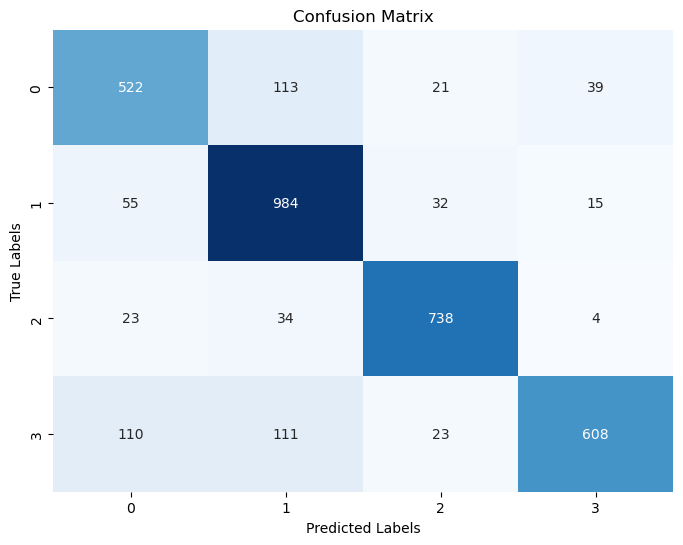

In [20]:
# Plot Confusion Matrix
def plot_confusion_matrix(true_labels, predictions):
    cm = confusion_matrix(true_labels, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Call the function using predictions and true labels
plot_confusion_matrix(eval_results['labels'], eval_results['predictions'])

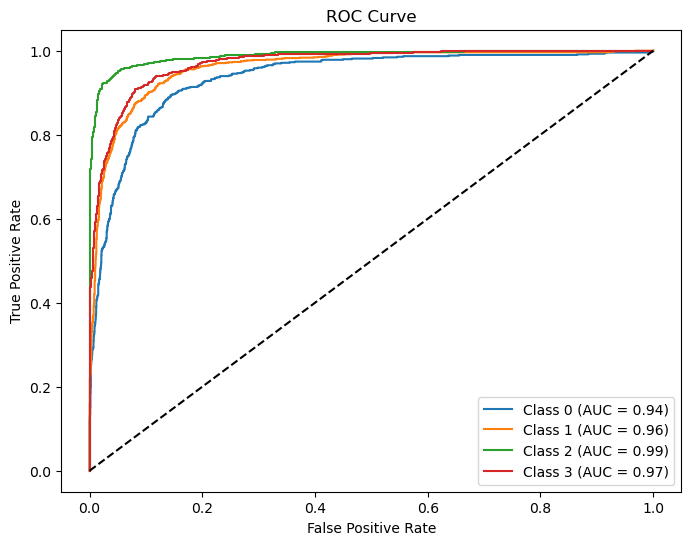

In [21]:
# Plot ROC curve
def plot_roc_curve(true_labels, pred_probs, num_classes):
    plt.figure(figsize=(8, 6))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(np.array(true_labels) == i, np.array(pred_probs)[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Random classifier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Call the function using true labels and prediction probabilities
plot_roc_curve(eval_results['labels'], eval_results['probabilities'], num_classes=4)